In [1]:
from pprint import pprint

# Data Processing

import re
import string
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

# Topic Modeling - LDA

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')

# lemmatization

import spacy

# Graphs

import pyLDAvis
import pyLDAvis.gensim
import matplotlib as plt1
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

In [3]:
# Calculate number of reviews in each product

df[['name', 'reviews.text']].groupby('name').agg('count')

,reviews.text
name,
"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",82
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",233
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",293
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",883
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",160
...,...
Kindle PowerFast International Charging Kit (for accelerated charging in over 200 countries),5
"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Free 3G + Wi-Fi - Includes Special Offers",36
"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers",505


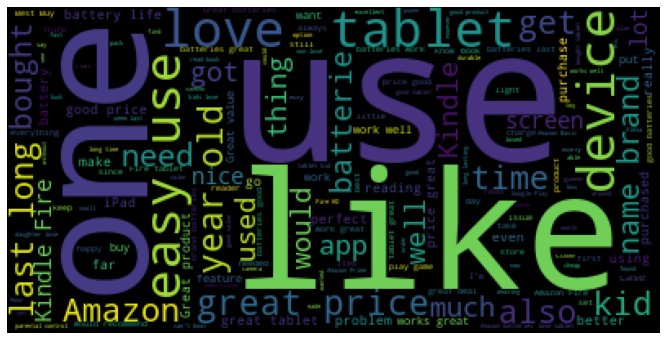

In [4]:
# Create word cloud from the entire corpus of reviews

stpWrds = set(stopwords.words('english'))
plt1.rcParams['figure.figsize'] = (12, 6)

reviewComb = df['reviews.text'].tolist()
finalText = ' '.join(reviewComb)


def generate_wordcloud(text):  # optionally add: stopwords=STOPWORDS and change the arg below

    wordcloud = WordCloud(stopwords=stpWrds).generate(text)  # set or space-separated string
    plt1.pyplot.imshow(wordcloud)
    plt1.pyplot.axis('off')
    plt1.pyplot.savefig('wordcloud.jpg')
    plt1.pyplot.show()


generate_wordcloud(finalText)

In [5]:
# Select a single product for the analysis

df = df[df['name']
        == 'AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary'
        ]  # choose one product

### Data Cleaning

In [6]:
df.dtypes

id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateSeen        object
reviews.didPurchase     object
reviews.doRecommend     object
reviews.id             float64
reviews.numHelpful     float64
reviews.rating           int64
reviews.sourceURLs      object
reviews.text            object
reviews.title           object
reviews.username        object
sourceURLs              object
dtype: object

In [7]:
# Convert date from string to datetime type

df['dateAdded'] = pd.to_datetime(df['dateAdded'])
df['updatedDate'] = df['dateAdded'].dt.year.astype(str) + '-' \
    + df['dateAdded'].dt.month.astype('str') + '-' + df['dateAdded'
        ].dt.day.astype('str')

In [8]:
# Remove duplicate reviews

df = df.drop_duplicates(subset='reviews.text', keep='last')

In [9]:
# Drop reviews having less than 20 characters

df = df[df['reviews.text'].apply(lambda x: len(x.split()) > 20)]

In [10]:
# Extract title and text of reviews

reviews_title = df["reviews.title"].tolist()
reviews_text = df["reviews.text"].tolist()

In [11]:
# Remove Punctuations

for i in range(len(reviews_text)):
    reviews_text[i] = reviews_text[i].translate(str.maketrans('', '',
            string.punctuation))
    
for i in range(len(reviews_title)):
    reviews_title[i] = reviews_title[i].translate(str.maketrans('', '',
            string.punctuation))

In [12]:
# If Review.title not in Review.text then append it to Review.text

i = 0
j = 0
for (i, j) in zip(range(len(reviews_title)),
                  range(len(reviews_text))):
    if reviews_title[i] not in reviews_text[j]:
        reviews_text[j] = reviews_text[j] + ' ' + reviews_title[i]

In [13]:
# Remove numbers

for text in range(len(reviews_text)):
    reviews_text[text] = ''.join(i for i in reviews_text[text]
                                 if not i.isdigit())

In [14]:
# Convert text to lower case

for text in range(len(reviews_text)):
    reviews_text[text] = reviews_text[text].lower()

In [15]:
for text in range(len(reviews_text)):
    reviews_text[text] = ' '.join(reviews_text[text].split())

### Text Lemmatization

In [16]:
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

lemm = WordNetLemmatizer()

lemmatized_word_list = list()

for review in reviews_text:
    string = review
    string = word_tokenize(string)  # tokenize the reviews

    string = ' '.join([lemm.lemmatize(w) for w in string])

    lemmatized_word_list.append(string)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Identifying Stop Words

In [17]:
stop_words = stopwords.words('english')
stop_words.extend(["review", "ive", "im", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y","z", "id", "em", "go", "wa", "rt", "hr", "ea", "mn", "ok", "im", "ta", "ha", "us", "le", "el", "cr", "bc", "yr", "mo", "op", "bv", "nd", "th", "cd", "pc", "ie", "mm", "dy", "iv", "wi", "qc", "oh", "na", "cu", "ii", "hf", "av", "lg", "ad", "eg"])
stop_words = list(set(stop_words))

filtered_word_list = list()

for i in range(0, len(lemmatized_word_list)):
    review_text = list()
    for word in lemmatized_word_list[i].split():
        if word not in stop_words:
            review_text.append(word)
        else: continue
    review_text = ' '.join(review_text)
    filtered_word_list.append(review_text)

### Word Tokenization

In [18]:
# Convert sentences to list of words

def sent_to_words(sentences):

    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

data_words = list(sent_to_words(filtered_word_list))

# print(data_words[:1])

In [19]:
# Build the bigram model; higher threshold will give fewer phrases

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [20]:
# Create bigrams

def make_bigrams(texts):
    return([bigram_mod[doc] for doc in texts])

In [21]:
# Form Bigrams

data_words_bigrams = make_bigrams(data_words)

data_lemmatized = data_words_bigrams

print(data_lemmatized[:1])

[['well', 'looking', 'cheap', 'nonrechargeable', 'battery', 'last', 'quite', 'perfect', 'nothing', 'say']]


In [22]:
# Create Dictionary

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus

texts = data_lemmatized

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]

# View

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


### Topic Modeling - Latent Dirichlet Allocation

In [23]:
# Calculate the coherence score for the LDA model

def compute_coherence_values(
    dictionary,
    corpus,
    texts,
    limit,
    start=2,
    step=1,
    ):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True,
            )

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts,
                dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return (model_list, coherence_values)

In [24]:
(model_list, coherence_values) = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data_lemmatized,
    limit=30,
    start=2,
    step=1,
    )

### Evaluating Model Performance

In [25]:
# Print the coherence scores

limit = 30
start = 2
step = 1
x = range(start, limit, step)

max_coherence_score = 0
model_number = 0

# select the model with the highest coherence score

for (m, cv) in zip(x, coherence_values):
    if max_coherence_score < cv:
        optimal_model = model_list[model_number]
        max_coherence_score = cv

    model_number += 1

    print('Number of Topics = ' + str(m) + ' has Coherence Value of ' + str(round(cv, 4)))

Number of Topics = 2 has Coherence Value of 0.3104
Number of Topics = 3 has Coherence Value of 0.3696
Number of Topics = 4 has Coherence Value of 0.3976
Number of Topics = 5 has Coherence Value of 0.4301
Number of Topics = 6 has Coherence Value of 0.4017
Number of Topics = 7 has Coherence Value of 0.4526
Number of Topics = 8 has Coherence Value of 0.4314
Number of Topics = 9 has Coherence Value of 0.4801
Number of Topics = 10 has Coherence Value of 0.4581
Number of Topics = 11 has Coherence Value of 0.4133
Number of Topics = 12 has Coherence Value of 0.4451
Number of Topics = 13 has Coherence Value of 0.4448
Number of Topics = 14 has Coherence Value of 0.4293
Number of Topics = 15 has Coherence Value of 0.4395
Number of Topics = 16 has Coherence Value of 0.3959
Number of Topics = 17 has Coherence Value of 0.4278
Number of Topics = 18 has Coherence Value of 0.4543
Number of Topics = 19 has Coherence Value of 0.4413
Number of Topics = 20 has Coherence Value of 0.419
Number of Topics = 21

In [26]:
# Select the model and print the topics (set of keywords)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.039*"timer" + 0.026*"acid" + 0.017*"arent" + 0.015*"inexpensive" + '
  '0.014*"extremely" + 0.013*"later" + 0.010*"talking" + 0.009*"played" + '
  '0.008*"fit" + 0.008*"happened"'),
 (1,
  '0.088*"battery" + 0.023*"great" + 0.021*"last" + 0.020*"price" + '
  '0.018*"good" + 0.018*"brand" + 0.015*"long" + 0.014*"work" + 0.013*"amazon" '
  '+ 0.011*"get"'),
 (2,
  '0.046*"size" + 0.045*"something" + 0.025*"plan" + 0.025*"regularly" + '
  '0.022*"roommate" + 0.022*"needsplit" + 0.021*"operated" + 0.019*"bang_buck" '
  '+ 0.017*"split" + 0.014*"digital"'),
 (3,
  '0.046*"candle" + 0.032*"worked" + 0.026*"three" + 0.016*"leaked" + '
  '0.015*"real" + 0.013*"put" + 0.012*"priced" + 0.009*"check" + '
  '0.009*"separate" + 0.009*"string"'),
 (4,
  '0.055*"screw" + 0.033*"however" + 0.029*"cabinet" + 0.028*"effect" + '
  '0.028*"tape" + 0.028*"client" + 0.028*"interior" + 0.028*"underneath" + '
  '0.028*"decorator" + 0.028*"dude"'),
 (5,
  '0.050*"lasting" + 0.040*"result" + 0.025*"re

In [27]:
# Compute Perplexity Score

print('Perplexity Score: {0}'.format(optimal_model.log_perplexity(corpus)))

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=optimal_model,
        texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: {0}'.format(coherence_lda))

Perplexity Score: -6.83491531220779

Coherence Score: 0.4801066061650098


### Visualizing Model Output

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)

In [29]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.428716 -0.009820       1        1  81.711990
7      0.067193 -0.065941       2        1   3.432555
6      0.064119 -0.275962       3        1   3.050334
5      0.058547  0.099242       4        1   3.008876
3      0.049421  0.077698       5        1   2.713033
2      0.056304  0.042874       6        1   2.138498
8      0.047753  0.043793       7        1   1.795934
0      0.042858  0.038982       8        1   1.330903
4      0.042520  0.049133       9        1   0.817879, topic_info=             Term         Freq        Total Category  logprob  loglift
0         battery  1937.000000  1937.000000  Default  30.0000  30.0000
50            put    65.000000    65.000000  Default  29.0000  29.0000
429       lasting    41.000000    41.000000  Default  28.0000  28.0000
701           son    46.000000    46.000000  Default  27.0000  27.0000
84          month    39.000000    39.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2744        strap     0.714866     1.353858   Topic9  -5.7329   4.1676
2678  ecofriendly     0.714483     1.353697   Topic9  -5.7334   4.1672
1474         zero     0.713631     1.352815   Topic9  -5.7346   4.1666
1198         sony     0.705856     1.344947   Topic9  -5.7455   4.1615
2741     included     0.705967     1.346596   Topic9  -5.7454   4.1604

[316 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
98        1  0.995618          aa
399       9  0.874319        able
2165      9  0.585421    absolute
901       8  0.988946        acid
568       3  0.932890  affordable
...     ...       ...         ...
3158      2  0.978518        yard
900       3  0.991764       youll
3151      3  0.965761        yuck
1474      9  0.739200        zero
3159      2  0.978518       zippy

[298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 7, 6, 4, 3, 9, 1, 5])

### Identifying Top 10 reviews based on the number of upvotes, timestamp and topics

In [30]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus,
                            texts=filtered_word_list):

    # Initialize output

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document

    for (i, row) in enumerate(ldamodel[corpus]):

        row = sorted(row[0], key=lambda x: x[1], reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document

        for (j, (topic_num, prop_topic)) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for (word, prop) in
                        wp])
                sent_topics_df = \
                    sent_topics_df.append(pd.Series([int(topic_num),
                        round(prop_topic, 4), topic_keywords]),
                        ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution',
                              'Topic_Keywords']

    # Add original text to the end of the output

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus,
                            texts=filtered_word_list)

# Format and display ouput

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                             'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9251,"battery, great, last, price, good, brand, long...",well looking cheap nonrechargeable battery las...
1,1,1.0,0.9463,"battery, great, last, price, good, brand, long...",dont last long name brand battery like duracel...
2,2,1.0,0.8546,"battery, great, last, price, good, brand, long...",fan offbrand battery far disappointed offbrand...
3,3,1.0,0.8627,"battery, great, last, price, good, brand, long...",got cant really comment good job good price qu...
4,4,1.0,0.9463,"battery, great, last, price, good, brand, long...",second purchase amazon battery work great good...
5,5,1.0,0.9523,"battery, great, last, price, good, brand, long...",amazon battery job although gave star would sa...
6,6,1.0,0.7901,"battery, great, last, price, good, brand, long...",find battery fail short time item like wireles...
7,7,1.0,0.6228,"battery, great, last, price, good, brand, long...",exploted damage charger bought going happen ch...
8,8,1.0,0.6520,"battery, great, last, price, good, brand, long...",battery horrible depend aa battery many wirele...
9,9,1.0,0.9748,"battery, great, last, price, good, brand, long...",pack lowest price per aa battery find anywhere...


In [31]:
# Group top 5 sentences under each topic

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for (i, grp) in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = \
        pd.concat([sent_topics_sorteddf_mallet,
                  grp.sort_values(['Perc_Contribution'],
                  ascending=[0]).head(10)], axis=0)

# Reset Index
# sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format and display ouput

sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib'
        , 'Keywords', 'Text']
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
74,1.0,0.9884,"battery, great, last, price, good, brand, long...",love battery happy bought battery super expens...
72,1.0,0.9817,"battery, great, last, price, good, brand, long...",going great deal detail battery reviewer done ...
9,1.0,0.9748,"battery, great, last, price, good, brand, long...",pack lowest price per aa battery find anywhere...
67,1.0,0.9741,"battery, great, last, price, good, brand, long...",mom young kid battery quick tried type battery...
11,1.0,0.9736,"battery, great, last, price, good, brand, long...",amazonbasics aa battery save lot time money go...
82,1.0,0.9716,"battery, great, last, price, good, brand, long...",used battery one game camera life theamazon ba...
672,1.0,0.9714,"battery, great, last, price, good, brand, long...",namebrand battery great cost bit lesserknown b...
80,1.0,0.9696,"battery, great, last, price, good, brand, long...",terrible changed battery wireless keyboard yes...
839,1.0,0.9694,"battery, great, last, price, good, brand, long...",bought thinking great save money well wonti us...
808,1.0,0.9687,"battery, great, last, price, good, brand, long...",work well name brand battery cheaper better qu...


In [32]:
# Top 10 reviews using LDA (based on topics discussed in the reviews)

indexes = sent_topics_sorteddf_mallet.head(10).index.values.tolist()
for i in indexes:
    print ('{0}. '.format(i) + df.iloc[i, 20], '\n')

# df.iloc[indexes, [20, 17, 1]]

74. I love these batteries. I am so happy that I bought them. Batteries are super expensive at my local retailer. It's sad when the batteries cost more than the thing you are putting them into. I paid about the same amount to get 48... Yes 48 AA batteries from Amazon as I would have paid to get 8 from my local retailer. I needed batteries for my new game trail camera. It takes 8 AA batteries and I was fearful that I was going to go into the poor house trying to keep fresh batteries in my trail camera. I went shopping online at Amazon and found these. I bought these several weeks ago. I used 8 AA from this box in my new trail camera. I am so happy with them. My trail camera has been in the woods several weeks and the batteries are still over 90 charged and that's after taking tons of video of game. These are working great and I saved a ton of cash. I am buying a box of the AAA now. I always seem to need them around the house for some reason. I am very happy with my new batteries from Am

In [33]:
# Top 10 reviews based on the number of upvotes

df_top = df.sort_values(by=['reviews.numHelpful'],
                        ascending=False).head(10)
for i in range(0, df_top.shape[0]):
    print('{0}. '.format(i + 1) + df_top.iloc[i, 20], '\n')

# df_top[['reviews.text', 'reviews.numHelpful', 'dateAdded']]

1. Well if you are looking for cheap non-rechargeable batteries that last quite a while then these are perfect. Nothing more to say. 

2. These don't last as long as name brand of batteries like Duracell or energizer. They are cheaper but I'd rather pay a little bit more and have them last a lot longer. 

3. I am not a fan of off-brand batteries and so far have been disappointed by off-brand battery performance. I have decided to give these batteries a try and thus far they have performed as expected. At this time I have a number of Amazon batteries because they are low cost. 

4. just got em so I can't really comment on how good the do the job, good price, quick delivery but have only put two into one of my keyboards but they can go up to a year so who can say after three days 

5. This was my second purchase of amazon batteries and they work great. Just as good or even better than name brand batteries and half the price. This will be the only way I purchase batteries from now on! 

6

In [34]:
# Top 10 reviews based on timestamp

df['dateAdded'] = df['dateAdded'].astype('datetime64[ns]')
df_top = df.sort_values(by=['dateAdded'], ascending=False).head(10)
for i in range(0, df_top.shape[0]):
    print('{0}. '.format(i + 1) + df_top.iloc[i, 20], '\n')

# df_top[['reviews.text', 'reviews.numHelpful', 'dateAdded']]

1. Well if you are looking for cheap non-rechargeable batteries that last quite a while then these are perfect. Nothing more to say. 

2. This is my second batch. These batteries are perfect for what I needed. In my experience, they seem to be just as good as the more expensive name brands. 

3. Great deal on these! Seem to have more initial power than most alkalines. Great for my electric razor! Get them if you have kids with lots of toys that eat batteries! 

4. Worked well. I got these for some remote control mice I had purchased. Much fun was had scaring the office staff. 

5. These are now my go-to batteries....sorry copper top. I used them for lights at my daughter's wedding and they are still going strong! 

6. Best way to have electronics work is having them be charged or have batteries! Buying this pack will fix the needing batteries part! 

7. My son goes through batteries like crazy so I bought him this pack for his birthday no complaints and they last a lot longer than doll

In [35]:
# Top 10 reviews based on the number of upvotes and timestamp

df_top = df.sort_values(by=['dateAdded', 'reviews.numHelpful'],
                        ascending=False).head(10)
for i in range(0, df_top.shape[0]):
    print('{0}. '.format(i + 1) + df_top.iloc[i, 20], '\n')

# df_top[['reviews.text', 'reviews.numHelpful', 'dateAdded']]

1. Well if you are looking for cheap non-rechargeable batteries that last quite a while then these are perfect. Nothing more to say. 

2. These don't last as long as name brand of batteries like Duracell or energizer. They are cheaper but I'd rather pay a little bit more and have them last a lot longer. 

3. I am not a fan of off-brand batteries and so far have been disappointed by off-brand battery performance. I have decided to give these batteries a try and thus far they have performed as expected. At this time I have a number of Amazon batteries because they are low cost. 

4. just got em so I can't really comment on how good the do the job, good price, quick delivery but have only put two into one of my keyboards but they can go up to a year so who can say after three days 

5. This was my second purchase of amazon batteries and they work great. Just as good or even better than name brand batteries and half the price. This will be the only way I purchase batteries from now on! 

6